### Classification of Waiting Times: Distinguishing Between Normal and High Durations Using the 'WAITTIME_BINARY' Indicator

This notebook presents a unified workflow for the classification of WAITTIME, effectively consolidating stages that were previously distributed across multiple scripts. It aims to distinguish between 'Normal' and 'High' waiting times using the 'WAITTIME_BINARY' variable, which categorizes WAITTIME based on a predefined threshold. The integration of data preprocessing, model training, evaluation, and visualization into a single notebook facilitates a streamlined analysis process. 

- **Unified Modeling Pipeline**: It combines key components from separate files into one notebook for predicting if WAITTIME will be normal or high.
- **Model Selection and Validation**: Cross-validation techniques are employed to select the best classification model.
- **Hyperparameter Optimization**: The chosen best model's hyperparameters are tuned using the validation set to maximize accuracy.
- **Model Evaluation**: The optimized the model is tested against a separate dataset to ensure accuracy and generalizability.

- **Importing Libraries**: Essential libraries for classification are imported to support modeling tasks.
- **Project Configuration**: Root setup and configurations are centralized through `config.py`, promoting consistent execution.
- **Data Preprocessing**: `DataPreprocessingPipeline` from the `utils.py` module located at /scripts/preprocessing/ ensures data is cleaned, engineered, split, and processed efficiently.
- **Class Organization**: Custom classes for preprocessing are maintained in the `scripts` directory, allowing for modular use.

- **File Organization**: Data files are organized and saved into subfolders within the `data` directory for better management.
- **Consistent Configuration**: `config.py` provides unified path management and global variables like `random_state` and `seed` for reproducibility.


In [1]:
# Install essential libraries for classification
import joblib
import sys
import numpy as np
import pandas as pd
import os
import joblib
import shap  # Import SHAP library
import seaborn as sns  # Import Seaborn for visualization
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score,make_scorer, classification_report, precision_recall_fscore_support
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve



from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
import shap
from sklearn.base import clone
from scipy import sparse as sp
from pathlib import Path

# Set the project root path
project_root = Path.cwd().parents[0]

# Insert the project root path to the system path
sys.path.insert(0, str(project_root))

# Import configuration settings
import config
from config import RANDOM_SEED

# Set the random seed
config.set_seed()

# Import our custom utility functions
from utils import DataPreprocessingPipeline

In [2]:

# Load the raw data from the data/raw directory using the load_data method from the config module located at config.org
emergency_df = config.load_data('nhamcs14.sas7bdat', 'raw')

####  **Data Preprocessing Pipeline**:

- **Data Preprocessing Pipeline**: The below section of the code uses a comprehensive pipeline located at /scripts/preprocessing/ for preprocessing data specifically for classification tasks with a focus on predicting the class of `WAITTIME_BINARY` variable. The key steps in this pipeline include:
  - **Data Preparation**: Applying a series of preprocessing techniques to clean and prepare the data for modeling.
  - **Dataset Splitting**: Segregating the preprocessed data into distinct training, validation, and testing sets to support various phases of model training and evaluation.
  - **Feature Recording**: Persistently storing the names of the features in a CSV file after preprocessing, which serves as a handy reference for later stages of the modeling process.


In [3]:
# Main target variable
target = 'WAITTIME_BINARY'
#Remove additional target variables that are not required for this task
target_to_drop = ['WAITTIME', 'LOV_BINARY']

# Create a data preprocessing pipeline
pipeline = DataPreprocessingPipeline(emergency_df=emergency_df, target=target, target_to_drop=target_to_drop, percent_train=0.70, percent_val=0.15, percent_test=0.15, stratify=False)
pipeline.run()

# Extract preprocessed data splits and other relevant information
X_train = pipeline.X_train
X_validation = pipeline.X_validation
X_test = pipeline.X_test
y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test
X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed
feature_names = pipeline.feature_names
cleaned_emergency_df = pipeline.cleaned_emergency_df
transformed_emergency_df = pipeline.transformed_emergency_df

preprocessor = pipeline.processor

# Clean up feature names for better readability
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]
feature_names_list = list(feature_names)

# Save feature names to a CSV file
config.save_data(feature_names, f"features_{target}.csv", 'features')

1-Cleaning data...
Data cleaning completed
Size of Initial dataset:(23844, 1012)
Size of cleaned dataset:(19197, 370)

2-Applying feature engineering...
Feature engineering completed
Size of the dataset after feature engineering:(19197, 387)

3-Splitting data...
self.stratify: False
Splitting data completed

4-Loading data...
train_df size: (13437, 387)
X_train size: (13437, 386)
y_train size: (13437,)

validation_df size: (2879, 387)
X_validation size: (2879, 386)
y_validation size: (2879,)

test_df size: (2881, 387)
X_test size: (2881, 386)
y_test size: (2881,)
Loading data completed

5-Preprocessing data...
Preprocessing data completed.
Processor saved successfully


#### Model Selection and Preservation
- **Classification Model Selection**: This next code section is responsible for the initialization and evaluation of a suite of classification models. Specifically, it:
  - **Model Dictionary Definition**: Establishes a dictionary that maps classification model names to their respective instances, each initialized with default parameters suitable for classification analysis.
  - **Performance Evaluation**: Employs cross-validation to assess the performance of each model based on the precision, recall, f1_score and roc_auc_score metrics.
  - **Model Loop**: Iterates over each model, performing cross-validation and calculating the precision, recall, f1_score and roc_auc_score for each fold.
  - **Best Model Update**: Dynamically updates the record of the best model if a candidate model demonstrates superior performance in terms of higher precision, recall, f1_score and roc scores.

- **Results and Preservation**: Upon completion of the evaluation:
  - **Best Model Display**: Outputs the details of the model that achieved the best cross-validation scores.
  - **Model Saving**: Serializes the best-performing model instance to a file for future reference and deployment.


In [4]:

# Define the models and their default parameters correctly wrapped in a dictionary under 'model'
models_defaults = {
    'LGBMClassifier': LGBMClassifier(random_state=RANDOM_SEED, verbose=0),
    'CatBoostClassifier': CatBoostClassifier(random_state=RANDOM_SEED, silent=True),
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_SEED),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric='logloss'),
    'MLPClassifier': MLPClassifier(random_state=RANDOM_SEED)
}

# Define scoring metrics
scoring_metrics = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score)
}

# Create a Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

model_scores = {}
best_model_name = None
best_model = None
best_f1 = 0  # Initial low F1 score

# Loop over each model and evaluate their performance using cross-validation
for model_name in models_defaults:
    model = models_defaults[model_name]
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor), ('resampling', SMOTE(random_state=RANDOM_SEED)), ('classifier', model)])
    
    # Perform cross-validation
    scores = cross_validate(pipeline, X_train, y_train, scoring=scoring_metrics, cv=cv, n_jobs=-1)
    
    # Calculate the average of the cross-validation scores
    mean_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring_metrics}
    model_scores[model_name] = mean_scores

    # Determine if this model is the best model
    if mean_scores['f1_weighted'] > best_f1:
        best_model_name = model_name
        best_model = model # Cloning the model to store its state
        best_f1 = mean_scores['f1_weighted']

# After scoring all models, create a DataFrame to store results
results = []
for model_name, scores in model_scores.items():
    results.append({
        'Model Name': model_name,
        'Precision': scores['precision'],
        'Recall': scores['recall'],
        'F1 Weighted': scores['f1_weighted'],
        'ROC AUC': scores['roc_auc'],
        'Is Best Model': 'Yes' if model_name == best_model_name else 'No'
    })
best_model = CatBoostClassifier(random_state=42, silent=True)
# Create the DataFrame
result_df = pd.DataFrame(results)

# Select only numerical columns and round them to two decimal places
numerical_cols = result_df.select_dtypes(include=np.number).columns
result_df[numerical_cols] = result_df[numerical_cols].round(2)

print("Best Model Based on F1 Weighted Score:")
print(f"Model Name: {best_model_name}")

# Save the best model instance, not its name
model_filename = "best_waittime_classification_model.joblib"
# Adjusted to directly save the model instance
config.save_model(best_model, model_filename) 
print(f"{model_filename} saved")

# Display the DataFrame
result_df


Best Model Based on F1 Weighted Score:
Model Name: CatBoostClassifier
best_waittime_classification_model.joblib saved


,Model Name,Precision,Recall,F1 Weighted,ROC AUC,Is Best Model
0,LGBMClassifier,0.69,0.60,0.74,0.71,No
1,CatBoostClassifier,0.69,0.62,0.74,0.72,Yes
2,RandomForestClassifier,0.69,0.47,0.70,0.67,No
3,XGBClassifier,0.66,0.60,0.73,0.70,No
4,MLPClassifier,0.57,0.54,0.67,0.65,No


#### Get n most important features using shap and the best model discovered "CatBoostClassifier"**:
  - **Top Feature Extraction**: This step is designed to identify the n most important features for the classification model based on the  using SHAP. 
  - **Strategies**: We will iterate over various values of 'n' to determine its correlation with performance metrics including precision, recall, F1 score, and ROC AUC score

100%|===================| 13419/13437 [03:53<00:00]        

n: 10, Precision: 0.69, Recall: 0.61, F1: 0.74, ROC AUC: 0.72


100%|===================| 13421/13437 [03:52<00:00]        

n: 20, Precision: 0.70, Recall: 0.64, F1: 0.76, ROC AUC: 0.74


100%|===================| 13394/13437 [03:53<00:00]        

n: 50, Precision: 0.70, Recall: 0.62, F1: 0.75, ROC AUC: 0.73

Best Model Configuration:
Best n: 20
F1 Score: 0.76, ROC AUC: 0.74


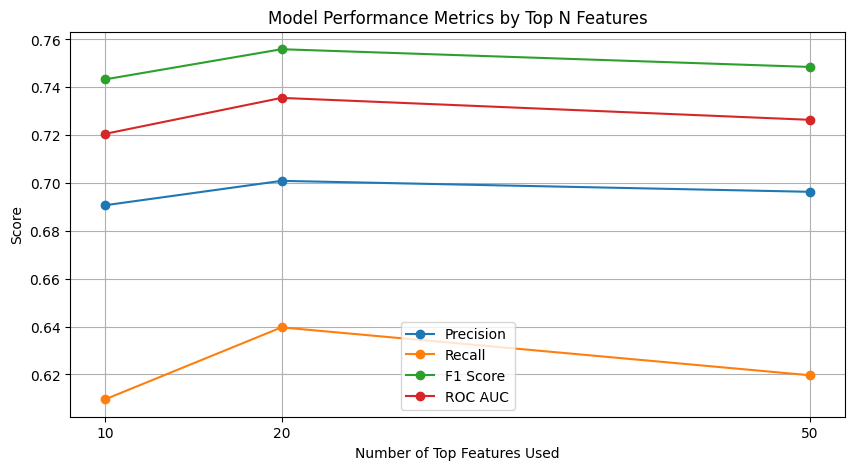

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Define the best model directly as specified
best_model = CatBoostClassifier(random_state=RANDOM_SEED, verbose=0)
best_n =  None
top_features = None
# Define a function to calculate SHAP values and return feature importances
def get_shap_importance(model, X_train):
    """Calculate SHAP values and return sorted feature importances."""
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer.shap_values(X_train)
    shap_importances = np.abs(shap_values).mean(axis=0)
    return shap_importances

# Define a function to fit a model using selected features and evaluate it
def evaluate_model_with_shap(model, X_train, y_train, X_validation, y_validation, feature_names, n):
    """Fit model, evaluate it, and return evaluation metrics and sorted features by importance."""
    model.fit(X_train, y_train)
    shap_importances = get_shap_importance(model, X_train)
    indices = np.argsort(shap_importances)[::-1][
        :n
    ]  # Get indices of the top n important features
    selected_feature_names = np.array(feature_names)[
        indices
    ]  # Sort feature names by importance

    X_train_n = X_train[:, indices]
    X_validation_n = X_validation[:, indices]

    model.fit(X_train_n, y_train)  # Refit model on selected features
    y_pred = model.predict(X_validation_n)
    precision = precision_score(y_validation, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_validation, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_validation, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_validation, y_pred)

    return precision, recall, f1, roc_auc, selected_feature_names

n_list = [10, 20, 50]
feature_names = [
    name.replace("num__", "").replace("cat__", "") for name in feature_names_list
]

precision_list, recall_list, f1_list, roc_auc_list,features_list = [], [], [], [], []

# Evaluate model for different values of n
for n in n_list:
    model = clone(best_model)  # Reset the model
    precision, recall, f1, roc_auc, selected_features = evaluate_model_with_shap(
         model, X_train_preprocessed, y_train, X_validation_preprocessed, y_validation, feature_names, n)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    features_list.append(selected_features) 

    print(f"n: {n}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, ROC AUC: {roc_auc:.2f}")

# Print the best configuration based on F1 score
best_index = np.argmax(f1_list)
best_n = n_list[best_index] 
top_features =  features_list[best_index] 
print(f"\nBest Model Configuration:")
print(f"Best n: {n_list[best_index]}")
print(f"F1 Score: {f1_list[best_index]:.2f}, ROC AUC: {roc_auc_list[best_index]:.2f}")


# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(n_list, precision_list, label='Precision', marker='o')
plt.plot(n_list, recall_list, label='Recall', marker='o')
plt.plot(n_list, f1_list, label='F1 Score', marker='o')
plt.plot(n_list, roc_auc_list, label='ROC AUC', marker='o')
plt.title('Model Performance Metrics by Top N Features')
plt.xlabel('Number of Top Features Used')
plt.ylabel('Score')
plt.xticks(n_list)
plt.legend()
plt.grid(True)
plt.show()


#### Feature Importance Visualization**:
  - **SHAP Summary Plot**: The following code cell generates a SHAP (SHapley Additive exPlanations) summary plot, which visually represents the impact of each most importante feature on t
  - **Saving Selected Features**: After pinpointing the key features, the code saves this subset for future use in classification modeling, ensuring that the model training is focused on the most relevant predictors.



100%|===================| 13404/13437 [03:53<00:00]        

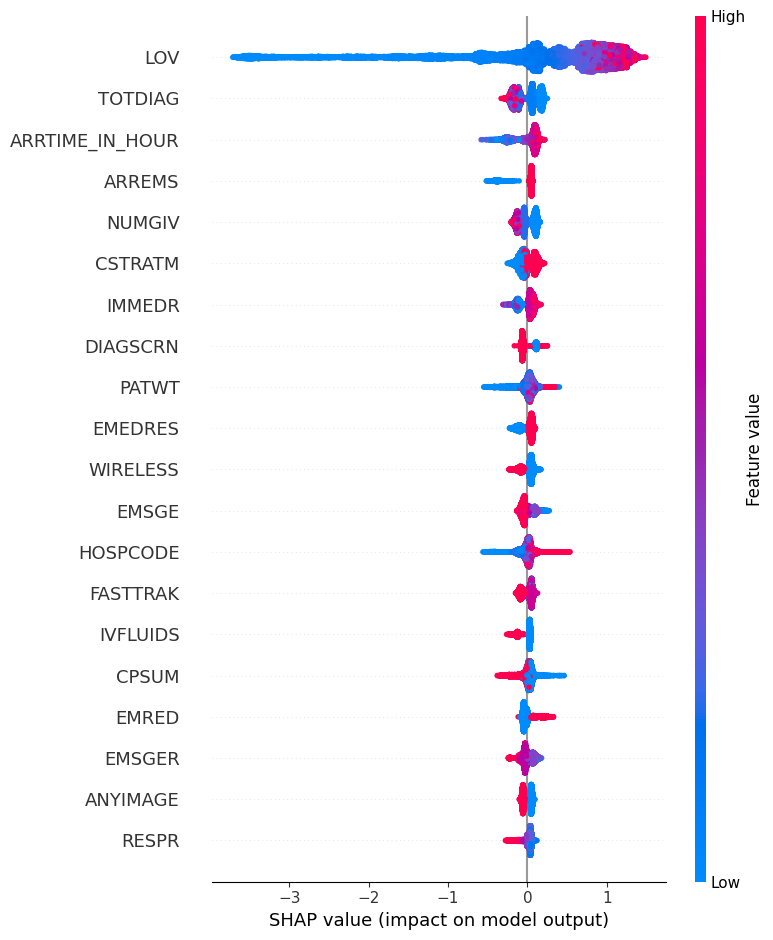

Top N Features (Cleaned Names): ['LOV' 'TOTDIAG' 'ARRTIME_IN_HOUR' 'ARREMS' 'NUMGIV' 'CSTRATM' 'IMMEDR'
 'DIAGSCRN' 'PATWT' 'EMEDRES' 'WIRELESS' 'EMSGE' 'HOSPCODE' 'FASTTRAK'
 'IVFLUIDS' 'CPSUM' 'EMRED' 'EMSGER' 'ANYIMAGE' 'RESPR']


In [6]:

model = clone(best_model)
model.fit(X_train_preprocessed, y_train)  # Ensure model is fitted

def plot_shap_summary(model, X_train_preprocessed, feature_names, n):
    """
    Plots SHAP summary plot of the top N features.

    Parameters:
    - model: The trained model.
    - X_train_preprocessed: The preprocessed training data.
    - feature_names: Names of the features after preprocessing.
    - n: Number of top features to consider.
    """
    # Initialize the SHAP Tree explainer and compute SHAP values
    explainer = shap.Explainer(model, X_train_preprocessed)
    shap_values = explainer.shap_values(X_train_preprocessed)

    # Plot the SHAP summary plot for the top N features
    shap.summary_plot(
        shap_values,
        X_train_preprocessed,
        feature_names=feature_names,
        max_display=n,
        show=True,
    )


# Extract top N features based on the earlier best_features selection
n = best_n  # This is set from the previous analysis
feature_names_list = [
    name.replace("num__", "").replace("cat__", "") for name in feature_names_list
] 

# Call the function to plot SHAP values for the top N feature names
plot_shap_summary(
    model=model,
    X_train_preprocessed=X_train_preprocessed,
    feature_names=feature_names_list,
    n=n,
)

# After plotting, continue with any additional processing or saving
print("Top N Features (Cleaned Names):", top_features)

# Extracting indices of top features directly since prefixes have been removed
top_feature_indices = [feature_names_list.index(feature) for feature in top_features]

X_train_selected_features = X_train_preprocessed[:, top_feature_indices]
X_validation_selected_features = (
    X_validation_preprocessed[:, top_feature_indices]
    if X_validation_preprocessed.size > 0
    else X_validation_preprocessed
)
X_test_selected_features = X_test_preprocessed[:, top_feature_indices]

# Save top n features
config.save_data(top_features, f"top_features_{target}.csv", "features")
config.save_data(top_feature_indices, f"feature_indices_{target}.csv", "features")

config.save_data(
    X_train_selected_features,
    f"X_train_selected_features_{target}.csv",
    subdir="train",
    column_names=top_features,
)
config.save_data(
    X_validation_selected_features,
    f"X_validation_selected_features_{target}.csv",
    subdir="validation",
    column_names=top_features,
)
config.save_data(
    X_test_selected_features,
    f"X_test_selected_features_{target}.csv",
    subdir="test",
    column_names=top_features,
)

#### Hyperparameter Tuning

- **Optimization Process**:
  - **GridSearchCV Application**: The code employs `GridSearchCV` to methodically explore different hyperparameter combinations for the best classification model, aiming to optimize predictions for wait time.
  - **Best Hyperparameters Utilization**: Once the optimal hyperparameters are identified, they are applied to train the final model across the entire training dataset.
  - **Validation Set Performance**: The model's effectiveness is assessed using the validation set to ensure its reliability and robustness.
  - **Model Saving**: The fine-tuned model, now ready for deployment, is saved to facilitate future use and further evaluation.


In [7]:

# Define a range of hyperparameters for CatBoostClassifier
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize CatBoostClassifier with auto_class_weights set to 'Balanced'
catboost_model = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced')

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=make_scorer(f1_score, average='weighted'),  # Using make_scorer to specify average method
    verbose=1
)

# Perform hyperparameter tuning
print("Starting hyperparameter tuning...")
grid_search.fit(X_train_selected_features, y_train)

# Retrieve and report the best hyperparameters
best_hyperparams = grid_search.best_params_
print(f"Best hyperparameters: {best_hyperparams}")



Starting hyperparameter tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


#### Model Retraining and Evaluation
  - **Focused Feature Set**: Utilizes only the top 60 features identified as most impactful, applying the best hyperparameters for retraining the model.
  - **Validation Prediction**: Makes predictions on the validation set to evaluate the refined model's performance.
  - **Model Saving**: Archives the trained model for future use.
  - **Confirmation**: Outputs a confirmation message upon successful completion of these steps.


In [8]:
# Training the final model with best hyperparameters
best_model = grid_search.best_estimator_

# Evaluate on validation set
y_validation_pred = best_model.predict(X_validation_selected_features)
y_validation_proba = best_model.predict_proba(X_validation_selected_features)[:, 1]  # For ROC AUC

# Calculate metrics                                             
f1_validation = f1_score(y_validation, y_validation_pred, average='weighted')
roc_auc_validation = roc_auc_score(y_validation, y_validation_proba)
precision_validation = precision_score(y_validation, y_validation_pred, average='weighted')
recall_validation = recall_score(y_validation, y_validation_pred, average='weighted')

print(f"Validation Metrics:\nF1 (Weighted): {f1_validation:.2f}, ROC AUC: {roc_auc_validation:.2f}, Precision (Weighted): {precision_validation:.2f}, Recall (Weighted): {recall_validation:.2f}")


#Metrics for each class
# Generate a classification report
report = classification_report(y_validation, y_validation_pred, output_dict=True)

# Print out the classification report
print(classification_report(y_validation, y_validation_pred))

# For a more custom output, you can also access specific metrics from the report dictionary:
for label, metrics in report.items():
    if label not in ('accuracy', 'macro avg', 'weighted avg'):
        print(f"Class {label} - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-score: {metrics['f1-score']:.2f}")

# # Save the best trained model 
model_filename = f"best_waittime_classification_model_tuned.joblib"
config.save_model(best_model, model_filename)

Validation Metrics:
F1 (Weighted): 0.74, ROC AUC: 0.82, Precision (Weighted): 0.76, Recall (Weighted): 0.74
              precision    recall  f1-score   support

         0.0       0.84      0.72      0.77      1780
         1.0       0.63      0.77      0.69      1099

    accuracy                           0.74      2879
   macro avg       0.73      0.75      0.73      2879
weighted avg       0.76      0.74      0.74      2879

Class 0.0 - Precision: 0.84, Recall: 0.72, F1-score: 0.77
Class 1.0 - Precision: 0.63, Recall: 0.77, F1-score: 0.69


#### Evaluation of Best Model on Test Data
  - **Model Loading**: Retrieves a previously trained classification model from storage.
  - **Test Data Evaluation**: Applies the model to the test data to assess its predictive accuracy.
  - **Metrics**: Computes the precision_score, recall_score, f1_score, roc_auc_score metrics to quantitatively measure the model's performance.
  - **Results Output**: Displays the calculated metrics, providing insights into the model’s effectiveness in real-world scenarios.



In [9]:
# Define the paths for the model and test data
model_name = 'best_waittime_classification_model_tuned.joblib'
# Load the trained model using the utility function from config.py
model = config.load_model(model_name)
print("Model loaded successfully.")


# Predict class labels for the test set
y_pred = model.predict(X_test_selected_features)

# Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test_selected_features)[:, 1]  # Probabilities for the positive class


Model loaded successfully.


#### Model Testing and Performance Evaluation
  - **Source File**: Retrieves the classification model from a `joblib` file named `best_waittime_classification_model_tuned.joblib`.
  - **Test Data Predictions**: Utilizes the loaded model to make predictions on the test dataset.
  - **Evaluation Metrics**: Calculates key performance indicators, including precision_score, recall_score, f1_score and roc_auc_score, to measure the model's accuracy and fit.


In [10]:
# Calculate the evaluation metrics
f1_validation = f1_score(y_test, y_pred, average='weighted')
roc_auc_validation = roc_auc_score(y_test, y_pred_proba)  # Ensure y_test is properly encoded for binary classification
precision_validation = precision_score(y_test, y_pred, average='weighted')
recall_validation = recall_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print(f"Validation Metrics:\nF1 (Weighted): {f1_validation:.2f}, ROC AUC: {roc_auc_validation:.2f}, Precision (Weighted): {precision_validation:.2f}, Recall (Weighted): {recall_validation:.2f}")

#Metrics for each class
# Generate a classification report
# Correct usage of classification_report to compare true labels and predicted labels
report = classification_report(y_test, y_pred, output_dict=True)

# Print out the classification report
print(classification_report(y_test, y_pred))

# Access specific metrics from the report dictionary for custom output, if needed
for label, metrics in report.items():
    if label not in ('accuracy', 'macro avg', 'weighted avg'):
        print(f"Class {label} - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-score: {metrics['f1-score']:.2f}")

Validation Metrics:
F1 (Weighted): 0.73, ROC AUC: 0.81, Precision (Weighted): 0.74, Recall (Weighted): 0.72
              precision    recall  f1-score   support

         0.0       0.83      0.70      0.76      1807
         1.0       0.60      0.75      0.67      1074

    accuracy                           0.72      2881
   macro avg       0.71      0.73      0.71      2881
weighted avg       0.74      0.72      0.73      2881

Class 0.0 - Precision: 0.83, Recall: 0.70, F1-score: 0.76
Class 1.0 - Precision: 0.60, Recall: 0.75, F1-score: 0.67


#### Visualization of Model Predictions
  - **1- Confusion matrix**
This confusion matrix shows the counts of true positive, true negative, false positive, and false negative predictions, providing a snapshot of the model performance.


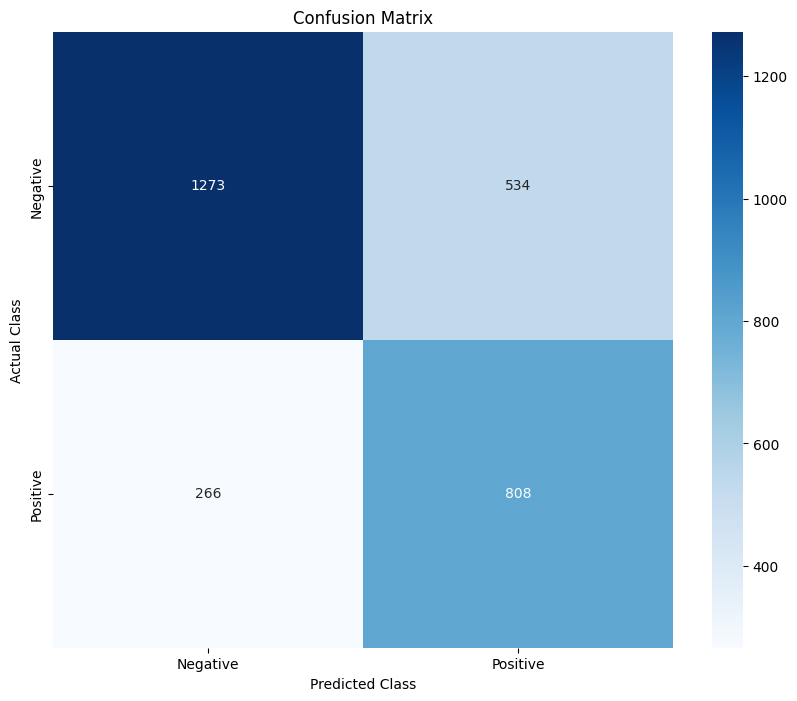

In [11]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()



 - **2- ROC Curve**
This (ROC) curve plots the true positive rate against the false positive rate at various threshold settings.

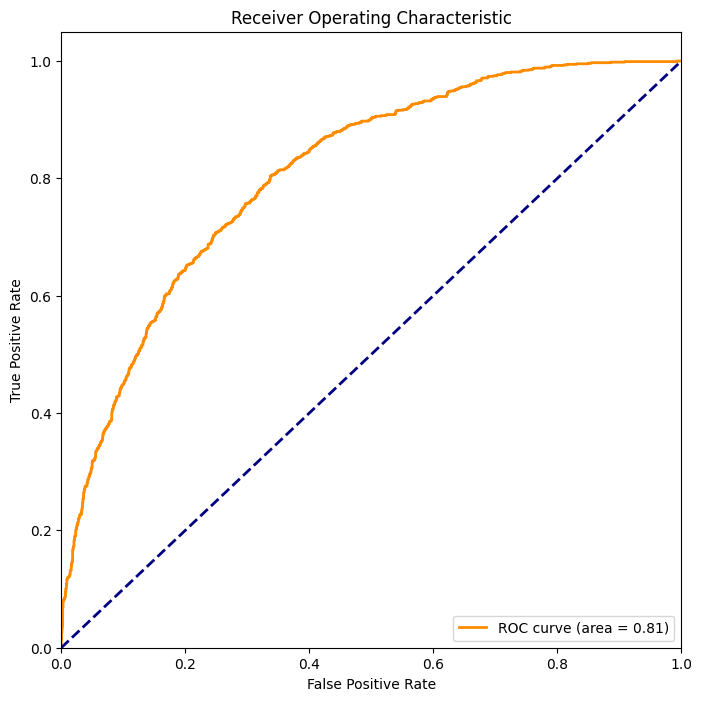

In [12]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


 - **3- Precision-Recall Curve**
This precision-Recall Curve plot is particularly useful for this project since classes are imbalanced. It provides a view of the trade-off between the precision and the recall for different probability thresholds.  

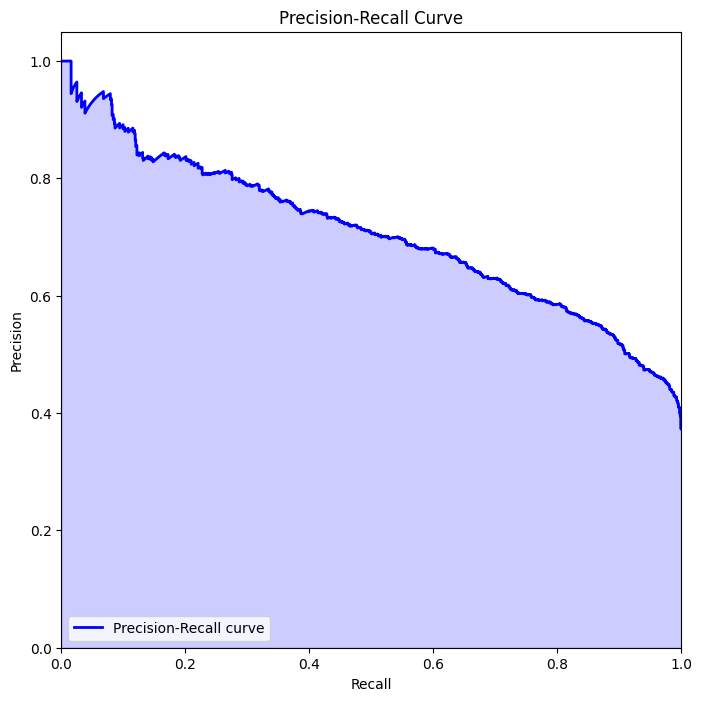

In [13]:
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


 - **4- Classification Report Heatmap**
This classification Report Heatmap provides precision, recall, and F1-score for each class. Visualizing these metrics in a heatmap can provide quick insights into model performance across classes.

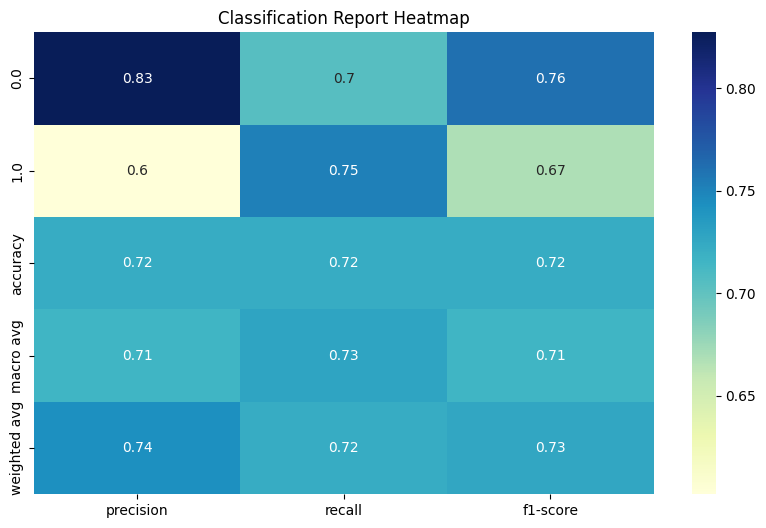

In [14]:
# Convert classification report to DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot heatmap of the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.drop(['support'], axis=1), annot=True, cmap="YlGnBu")
plt.title('Classification Report Heatmap')
plt.show()
